<a href="https://colab.research.google.com/github/myutman/DUL/blob/HW3/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.functional import F

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

device = torch.device('cuda:0')

#1. Vae 2d

## a)

In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
        [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.normal = torch.distributions.normal.Normal(0, 1)

    def encode(self, x):
        pass

    def reparametrize(self, mu, sigma):
        if self.training:
            z = self.normal.sample(mu.shape).to(device)
            return mu + z * sigma
        else:
            return mu

    def decode(self, z):
        pass

    def forward(self, x):
        mu1, sigma1 = self.encode(x)
        z = self.reparametrize(mu1, sigma1)
        mu2, sigma2 = self.decode(z)
        return mu1, sigma1, mu2, sigma2

class VAE1(VAE):
    def __init__(self):
        super(VAE1, self).__init__()

        self.mu_encode = nn.Linear(64, 2)
        self.sigma_encode = nn.Linear(64, 2)
        torch.nn.init.zeros_(self.sigma_encode.weight)

        self.mu_decode = nn.Linear(64, 2)
        self.sigma_decode = nn.Linear(64, 2)
        torch.nn.init.zeros_(self.sigma_decode.weight)
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu_encode(x)
        sigma = self.sigma_encode(x).exp()
        return mu, sigma
    
    def decode(self, z):
        x = self.decoder(z)
        mu = self.mu_decode(x)
        sigma = self.sigma_decode(x).exp()
        return mu, sigma

class VAE2(VAE):
    def __init__(self):
        super(VAE2, self).__init__()

        self.mu_encode = nn.Linear(64, 2)
        self.sigma_encode = nn.Linear(64, 2)
        torch.nn.init.zeros_(self.sigma_encode.weight)

        self.mu_decode = nn.Linear(64, 2)
        self.sigma_decode = nn.Linear(64, 1)
        torch.nn.init.zeros_(self.sigma_decode.weight)
    
    def encode(self, x):
        x = self.encoder(x)
        mu = self.mu_encode(x)
        sigma = self.sigma_encode(x).exp()
        return mu, sigma
    
    def decode(self, z):
        x = self.decoder(z)
        mu = self.mu_decode(x)
        sigma = self.sigma_decode(x).exp() * torch.ones(2).to(device)
        return mu, sigma

def KL(mu, sigma):
    return torch.mean(sigma.sum(dim=-1) + (mu**2).sum(dim=-1) - 2 - torch.log(sigma.prod(dim=-1) + 1e-9)) / 2

def CrossEntropy(mu, sigma, x):
    return torch.mean((torch.log(sigma.prod(dim=-1) + 1e-9) + 2 * np.log(2 * np.pi) + ((x - mu)**2 * sigma**(-1)).sum(dim=-1)) / 2)

class ELBOLoss(nn.Module):
    def __init__(self):
        super(ELBOLoss, self).__init__()
    
    def forward(self, input, mu_e, sigma_e, mu_d, sigma_d):
        self.kl = KL(mu_e, sigma_e)
        self.ce = CrossEntropy(mu_d, sigma_d, input)
        return self.kl + self.ce

In [0]:
def train(model, train, test, loss_function, n_epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    train_kl = []
    test_kl = []
    for i in tqdm(range(n_epochs)):
        model.train()
        train_losses = []
        train_kls = []
        for batch in train:
            optimizer.zero_grad()
            mu_e, sigma_e, mu_d, sigma_d = model(batch.float().to(device))
            #print(mu.shape, sigma.shape, output.shape)
            loss = loss_function(batch.float().to(device), mu_e, sigma_e, mu_d, sigma_d)
            train_losses.append(float(loss.cpu().float()))

            kl = loss_function.kl.cpu()
            train_kls.append(float(kl.float()))
            loss.backward()
            optimizer.step()
        #if (np.isnan(np.mean(train_losses))):
        #    print(train_losses)
        train_loss.append(np.mean(train_losses))
        train_kl.append(np.mean(train_kls))

        with torch.no_grad():
            model.eval()
            test_losses = []
            test_kls = []
            for batch in test:
                mu_e, sigma_e, mu_d, sigma_d = model(batch.float().to(device))
                loss = loss_function(batch.float().to(device), mu_e, sigma_e, mu_d, sigma_d)
                test_losses.append(float(loss.cpu().float()))

                kl = loss_function.kl.cpu()
                #print('test:', loss)
                test_kls.append(float(kl.float()))
            test_loss.append(np.mean(test_losses))
            test_kl.append(np.mean(test_kls))

    return train_loss, test_loss, train_kl, test_kl

In [39]:
dataset = sample_data_1()
train_data, test_data = train_test_split(dataset, test_size=0.2)
train_batches = data.DataLoader(train_data, batch_size=1024)
test_batches = data.DataLoader(test_data, batch_size=1024)

model1 = VAE1()
model1.to(device)

model2 = VAE2()
model2.to(device)

elboloss = ELBOLoss()
elboloss.to(device)

num_epochs = 150
train_losses1, test_losses1, train_kl1, test_kl1 = train(model1, train_batches, test_batches, elboloss, num_epochs, 1e-4)

In [42]:
train_losses2, test_losses2, train_kl2, test_kl2 = train(model2, train_batches, test_batches, elboloss, num_epochs, 1e-4)

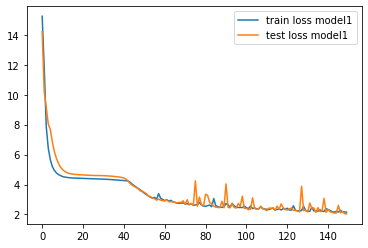

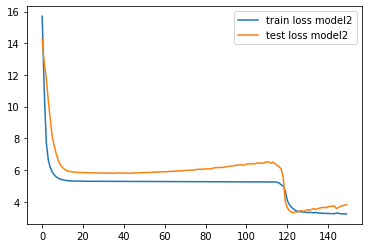

In [43]:
plt.figure()
plt.plot(range(num_epochs), train_losses1)
plt.plot(range(num_epochs), test_losses1)
plt.legend(['train loss model1', 'test loss model1'])

plt.figure()
plt.plot(range(num_epochs), train_losses2)
plt.plot(range(num_epochs), test_losses2)
plt.legend(['train loss model2', 'test loss model2'])

plt.show()

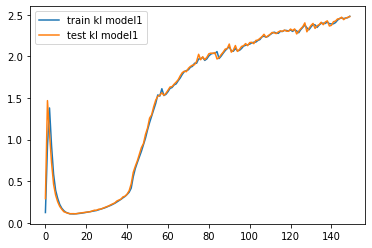

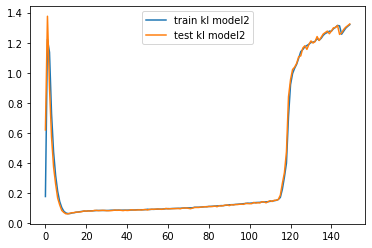

In [44]:
plt.figure()
plt.plot(range(num_epochs), train_kl1)
plt.plot(range(num_epochs), test_kl1)
plt.legend(['train kl model1', 'test kl model1'])

plt.figure()
plt.plot(range(num_epochs), train_kl2)
plt.plot(range(num_epochs), test_kl2)
plt.legend(['train kl model2', 'test kl model2'])

plt.show()

In [0]:
def sample(model, is_train, n):
    if is_train:
        model.train()
    else:
        model.eval()
    z = model.normal.sample((n, 2)).to(device)
    mu, sigma = model.decode(z)
    return model.reparametrize(mu, sigma)

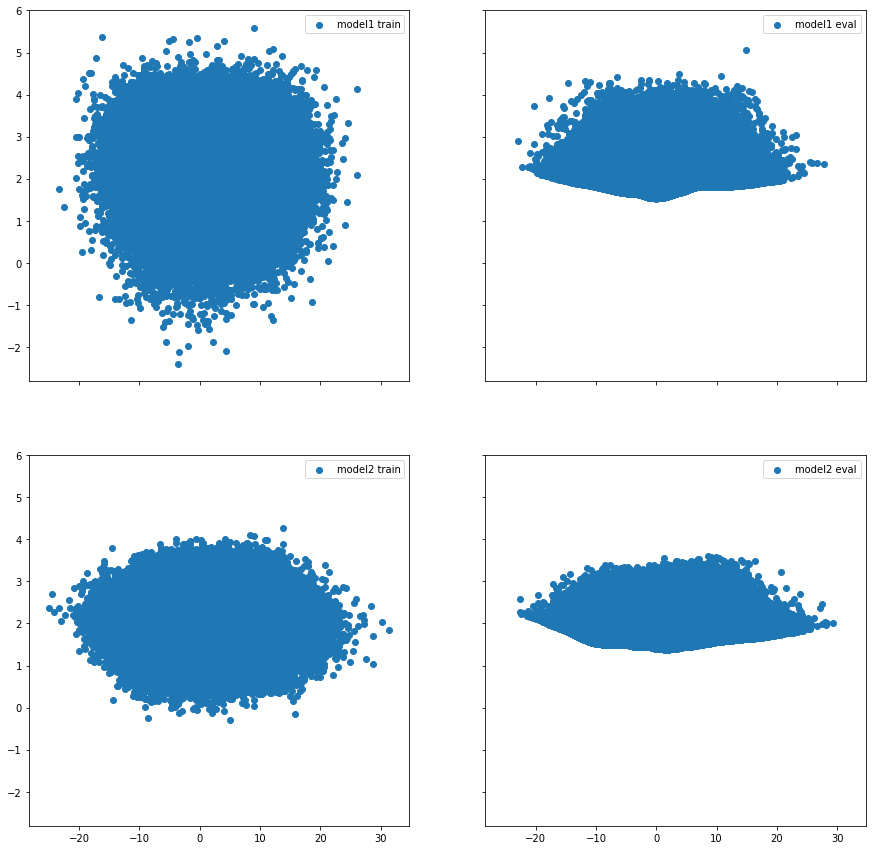

In [46]:
fig = plt.figure(figsize=(15, 15))

ax = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

sampled = sample(model1, True, 100000).cpu().detach().numpy()
ax[0][0].scatter(x=sampled[:,0], y=sampled[:,1])
ax[0][0].legend(['model1 train'])

sampled = sample(model1, False, 100000).cpu().detach().numpy()
ax[0][1].scatter(x=sampled[:,0], y=sampled[:,1])
ax[0][1].legend(['model1 eval'])

sampled = sample(model2, True, 100000).cpu().detach().numpy()
ax[1][0].scatter(x=sampled[:,0], y=sampled[:,1])
ax[1][0].legend(['model2 train'])

sampled = sample(model2, False, 100000).cpu().detach().numpy()
ax[1][1].scatter(x=sampled[:,0], y=sampled[:,1])
ax[1][1].legend(['model2 eval'])

plt.show()

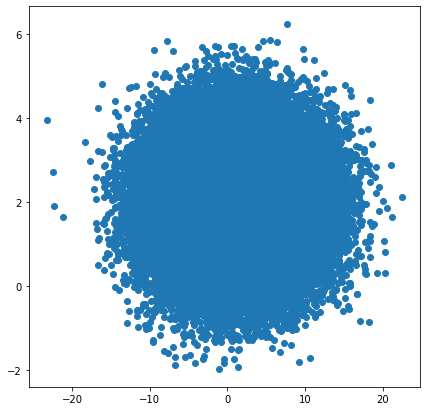

In [63]:
plt.figure(figsize=(7, 7))

plt.scatter(x=train_data[:,0], y=train_data[:,1])
plt.show()

In [47]:
dataset = sample_data_2()
train_data, test_data = train_test_split(dataset, test_size=0.2)
train_batches = data.DataLoader(train_data, batch_size=1024)
test_batches = data.DataLoader(test_data, batch_size=1024)

model1 = VAE1()
model1.to(device)

model2 = VAE2()
model2.to(device)

elboloss = ELBOLoss()
elboloss.to(device)

num_epochs = 150
train_losses1, test_losses1, train_kl1, test_kl1 = train(model1, train_batches, test_batches, elboloss, num_epochs)
train_losses2, test_losses2, train_kl2, test_kl2 = train(model2, train_batches, test_batches, elboloss, num_epochs)

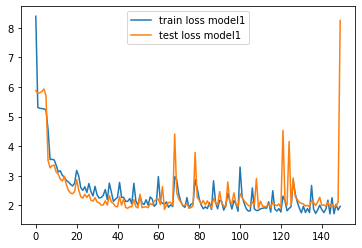

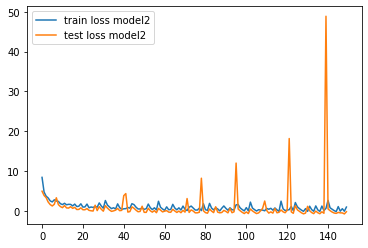

In [48]:
plt.figure()
plt.plot(range(num_epochs), train_losses1)
plt.plot(range(num_epochs), test_losses1)
plt.legend(['train loss model1', 'test loss model1'])

plt.figure()
plt.plot(range(num_epochs), train_losses2)
plt.plot(range(num_epochs), test_losses2)
plt.legend(['train loss model2', 'test loss model2'])

plt.show()

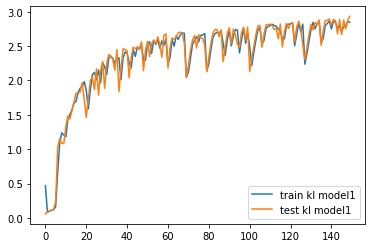

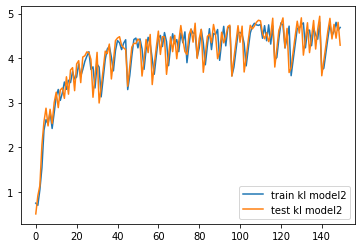

In [49]:
plt.figure()
plt.plot(range(num_epochs), train_kl1)
plt.plot(range(num_epochs), test_kl1)
plt.legend(['train kl model1', 'test kl model1'])

plt.figure()
plt.plot(range(num_epochs), train_kl2)
plt.plot(range(num_epochs), test_kl2)
plt.legend(['train kl model2', 'test kl model2'])

plt.show()

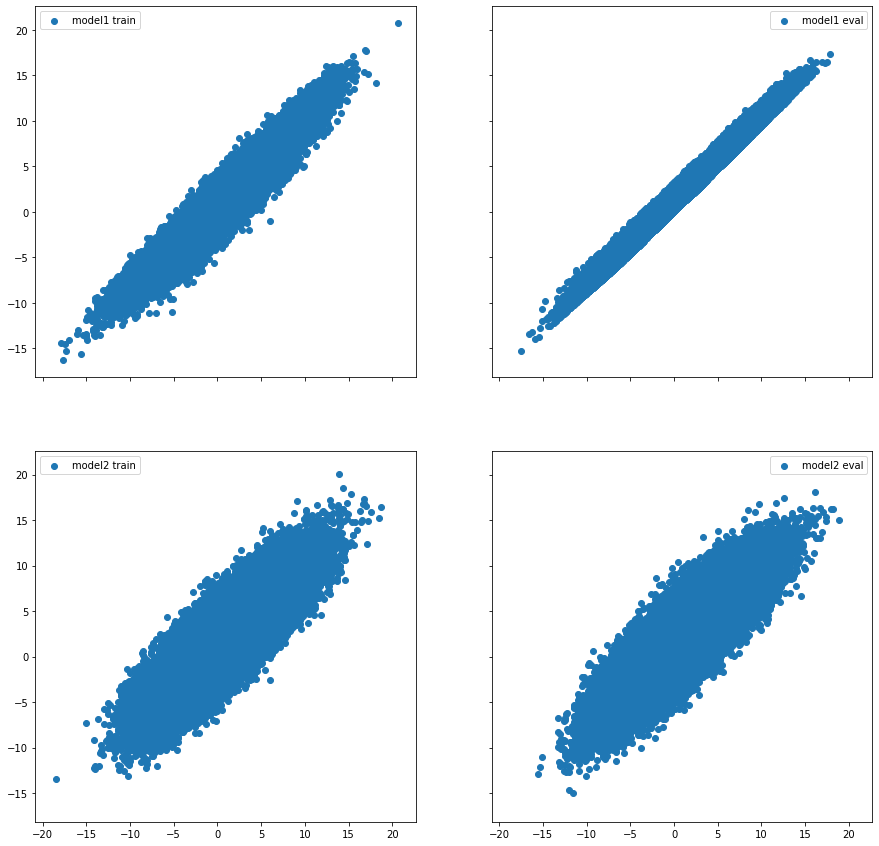

In [50]:
fig = plt.figure(figsize=(15, 15))

ax = fig.subplots(nrows=2, ncols=2, sharex=True, sharey=True)

sampled = sample(model1, True, 100000).cpu().detach().numpy()
ax[0][0].scatter(x=sampled[:,0], y=sampled[:,1])
ax[0][0].legend(['model1 train'])

sampled = sample(model1, False, 100000).cpu().detach().numpy()
ax[0][1].scatter(x=sampled[:,0], y=sampled[:,1])
ax[0][1].legend(['model1 eval'])

sampled = sample(model2, True, 100000).cpu().detach().numpy()
ax[1][0].scatter(x=sampled[:,0], y=sampled[:,1])
ax[1][0].legend(['model2 train'])

sampled = sample(model2, False, 100000).cpu().detach().numpy()
ax[1][1].scatter(x=sampled[:,0], y=sampled[:,1])
ax[1][1].legend(['model2 eval'])

plt.show()

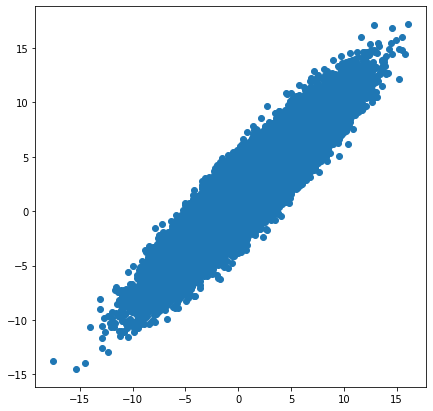

In [70]:
plt.figure(figsize=(7, 7))

plt.scatter(x=train_data[:,0], y=train_data[:,1])
plt.show()

##b)

In [0]:
def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
            -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [7]:
dataset, labels = sample_data_3()
train_data, test_data = train_test_split(dataset, test_size=0.2)
train_batches = data.DataLoader(train_data, batch_size=10000)
test_batches = data.DataLoader(test_data, batch_size=10000)

model = VAE1()
model.to(device)

elboloss = ELBOLoss()
elboloss.to(device)

num_epochs = 1000
train_losses, test_losses, train_kl, test_kl = train(model, train_batches, test_batches, elboloss, num_epochs, 2e-4)

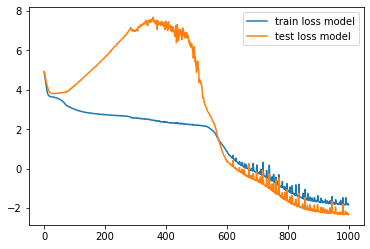

In [9]:
plt.plot(range(num_epochs), train_losses)
plt.plot(range(num_epochs), test_losses)
plt.legend(['train loss model', 'test loss model'])

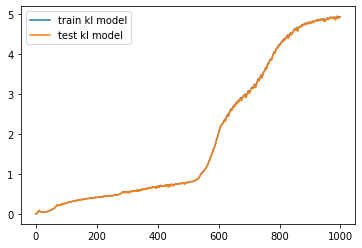

In [10]:
plt.plot(range(num_epochs), train_kl)
plt.plot(range(num_epochs), test_kl)
plt.legend(['train kl model', 'test kl model'])

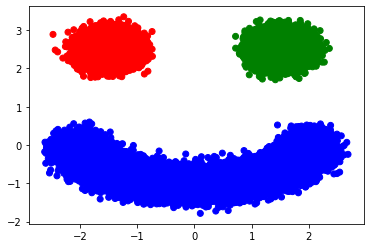

In [11]:
colors = np.array(['r', 'g', 'b'])[labels]
plt.scatter(x=dataset[:,0], y=dataset[:,1], c=colors)

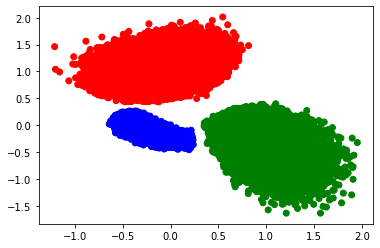

In [12]:
mu, sigma = model.encode(torch.tensor(dataset, dtype=torch.float32).to(device))
z = model.reparametrize(mu, sigma).cpu().detach().numpy()
plt.scatter(x=z[:,0], y=z[:,1], c=colors)

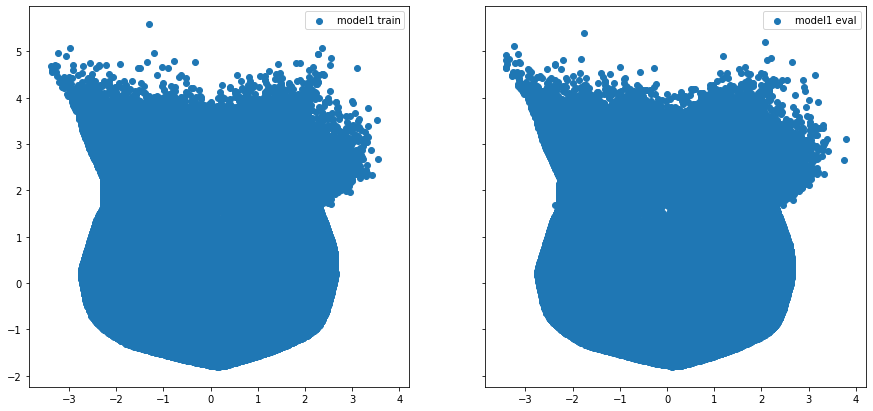

In [15]:
fig = plt.figure(figsize=(15, 7))

ax = fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

sampled = sample(model, True, 100000).cpu().detach().numpy()
ax[0].scatter(x=sampled[:,0], y=sampled[:,1])
ax[0].legend(['model1 train'])

sampled = sample(model, False, 100000).cpu().detach().numpy()
ax[1].scatter(x=sampled[:,0], y=sampled[:,1])
ax[1].legend(['model1 eval'])

plt.show()

# High-dimensional data

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, nin):
        super(ResidualBlock, self).__init__()
        self.seq = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d()
        )